# Convert MERRA-2 wind direction from regular lat/lon to EPSG 3031

In [214]:
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import os
import glob

import matplotlib.pyplot as plt
import re

In [215]:
def read_smet(path, var):
    """ Reads a .smet file and returns a time series of the defined variable as a pandas data frame.
    Args:
        path (str): String pointing to the location of the .smet file to be read.
        var  (str): Variable you want to plot
    Returns:
        Time series of defined variable as a pandas data frame.
    """

    # Load .smet file as a Pandas data frame
    df = pd.read_csv(path)
    
    # Get latitude and longitude
    '''
    Note that this code will only work for negative latitudes and longitudes because of the pattern matching! 
    So lat and lon will be off if this is not the case! 
    To fix this I need to find a way to extract both negative and positive decimal numbers from strings. 
    '''
    lat_line = np.where(df[df.columns[0]].str.startswith("latitude"))[0][0]
    lon_line = np.where(df[df.columns[0]].str.startswith("longitude"))[0][0]
    lat = float(re.findall('-\d*\.?\d+', df['SMET 1.1 ASCII'][lat_line])[0])
    lon = float(re.findall('-\d*\.?\d+', df['SMET 1.1 ASCII'][lon_line])[0])

    # Determine indices for data retrieval
    bump = 2
    fields_row = np.where(df[df.columns[0]].str.startswith("fields"))[0][0] + bump
    data_row = np.where(df[df.columns[0]] == '[DATA]')[0][0] + bump
    fields =  np.loadtxt(path, skiprows=fields_row - 1, max_rows=1, dtype='str')
    data_col = np.where(fields == var)[0][0] - bump

    # Creates pandas data frame
    time = np.loadtxt(path, skiprows=data_row, usecols=0, dtype = 'str')
    time = pd.to_datetime(time, format='%Y-%m-%dT%H:%M:%S')
    data = np.loadtxt(path, skiprows=data_row, usecols=data_col)
    ts = pd.DataFrame(data, index=time)

    # Set no data values to nan
    ts[ts == -999] = np.nan

    # Return time series as Pandas data frame
    return ts, lat, lon

def wswd_to_U(ws, wd):
    '''
    Calculates U wind component from wind speed (ws) and direction (wd, degrees). 
    '''
    
    return - ws * np.sin(np.deg2rad(wd))
    
def wswd_to_V(ws, wd):
    '''
    Calculates V wind component from wind speed (ws) and direction (wd, degrees). 
    '''
    
    return - ws * np.cos(np.deg2rad(wd))

def uv_to_wd(u, v):
    '''
    Calculates wind direction (wd, degrees) from u and v components of wind (u, v). 
    '''
    
    return np.fmod(np.rad2deg(np.arctan2(u, v)) + 180.0, 360.0)

def rotate_u_v(src_lon, src_lat, src_u, src_v):
    '''
    Rotates the u and v components of wind from WGS 84 (regular latititude and longitude) to EPSG:3031 (Antarctic polar stereographic projection). 
    '''   
    
#     src_proj = ccrs.PlateCarree() 
    src_proj = ccrs.SouthPolarStereo() 
    tgt_proj = ccrs.SouthPolarStereo()
    u_rot, v_rot = tgt_proj.transform_vectors(src_proj, src_lon, src_lat, src_u, src_v)
    
    return u_rot, v_rot

In [216]:
# src_dir = glob.glob("../../input/meteo/*.smet")
src_dir = glob.glob("../../snowpack/Scripts/create_smet_from_netcdf/output/MERRA-2_2019/*smet")

# for filename in src_dir:
for filename in src_dir[0:1]:
    print(filename)
    
    # Calculate wind direction in EPSG 3031
    ws, lat, lon = read_smet(filename, "VW")
    wd, lat, lon = read_smet(filename, "DW")
    u = wswd_to_U(ws, wd)
    v = wswd_to_V(ws, wd)
    u_rot, v_rot = rotate_u_v(np.repeat(lon, len(u[0])), np.repeat(lat, len(u[0])), u[0].values, v[0].values)
    wd_rot = uv_to_wd(u_rot, v_rot)

../../snowpack/Scripts/create_smet_from_netcdf/output/MERRA-2_2019/VIR13.smet


Mean Wind Direction = 42.975378763437334 degrees


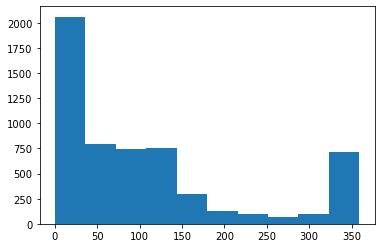

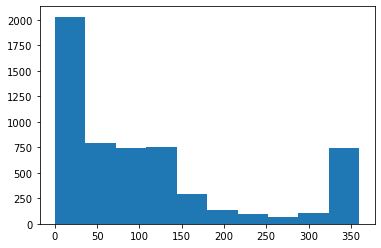

In [217]:
plt.figure()
plt.hist(wd_rot)

plt.figure()
plt.hist(wd[0].values)

mean_wd = uv_to_wd(u_rot.mean(), v_rot.mean())
print("Mean Wind Direction = " + str(mean_wd) + " degrees")

In [218]:
wd

,0
2019-01-01 00:30:00,10.0
2019-01-01 01:30:00,14.0
2019-01-01 02:30:00,18.0
2019-01-01 03:30:00,22.0
2019-01-01 04:30:00,25.0
...,...
2019-08-28 19:30:00,174.0
2019-08-28 20:30:00,164.0
2019-08-28 21:30:00,155.0
2019-08-28 22:30:00,144.0
